# Modeling COVID-19 Pandemic in London with Epydemix

In this tutorial we will develop an epidemic models for COVID-19 and we will calibrate it to real data on daily deaths during the first wave in London. 

Let's import needed packages:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from epydemix.model import EpiModel, simulate, Population
from epydemix.visualization import plot_selected_quantiles, plot_posterior, plot_posterior_2d
from epydemix.calibration import calibrate
from epydemix.utils import compute_simulation_dates, convert_to_2Darray
import numpy as np 
from scipy import stats 

ModuleNotFoundError: No module named 'epydemix'

Second, we import and plot the epidemic data on daily deaths that we want to model:

<Axes: title={'center': 'London'}, xlabel='date', ylabel='daily deaths'>

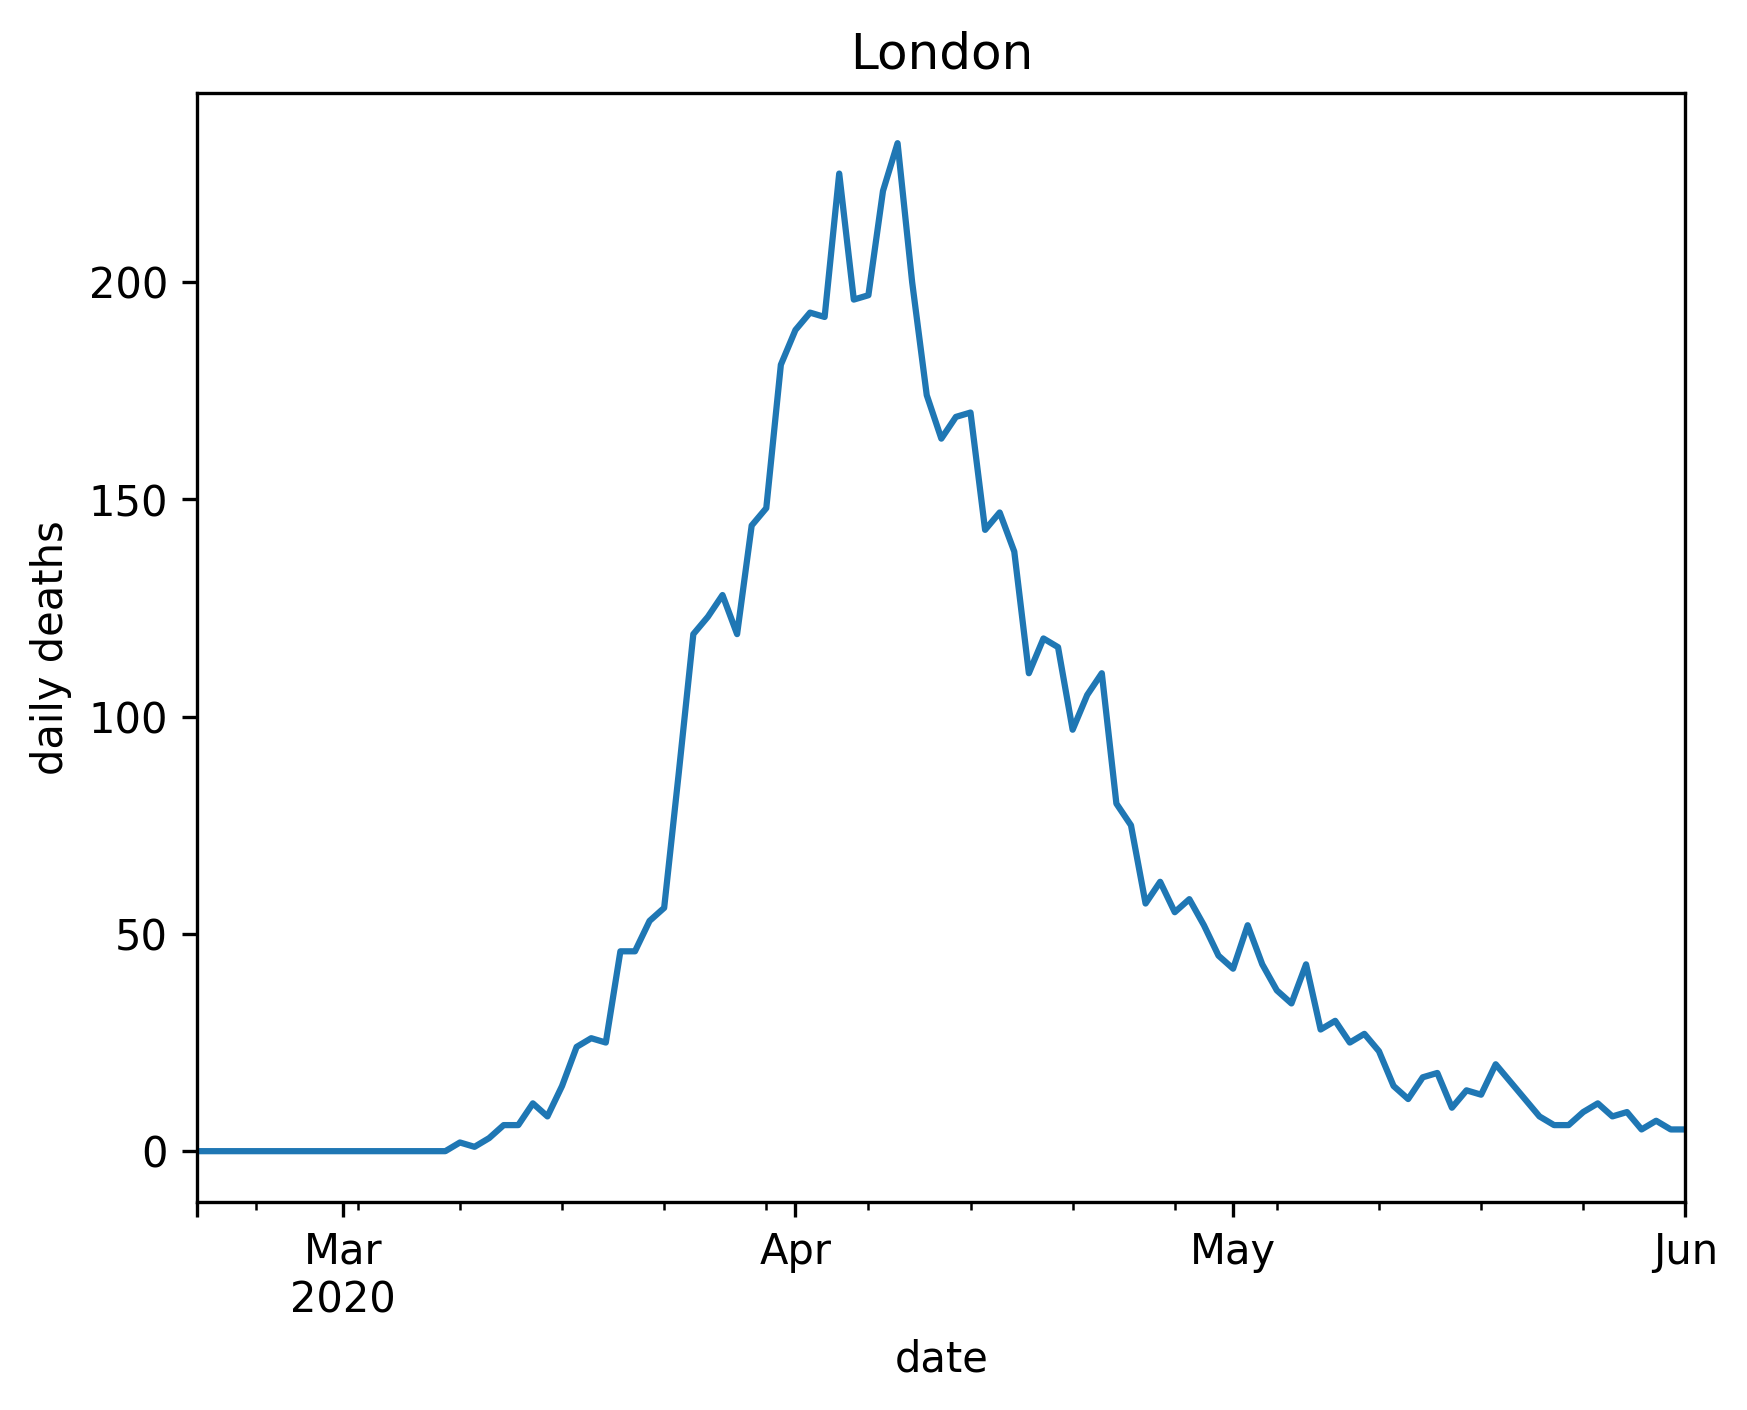

In [23]:
# import epidemic data 
epi_data = pd.read_csv("./data/london/epi-data/epi_data.csv")
epi_data.index = pd.to_datetime(epi_data.date)

fig, ax = plt.subplots(dpi=300)
epi_data.new_deaths.plot(ax=ax, title="London", ylabel="daily deaths")

Then, we import mobility data from the COVID-19 Community Mobility Report published by Google. Since the first wave of COVI-19 was controlled via the implementation of non-pharmaceutical interventions, we need to account for this into our model. We will use mobility data to compute a contact reduction parameter $r(t)$ that will modulate the transmission rate of our epidemic model. For more detail on similar approaches see REFS:

<Axes: title={'center': 'Contact reductions in London - COVID-19 First wave'}, xlabel='date', ylabel='$r(t)$'>

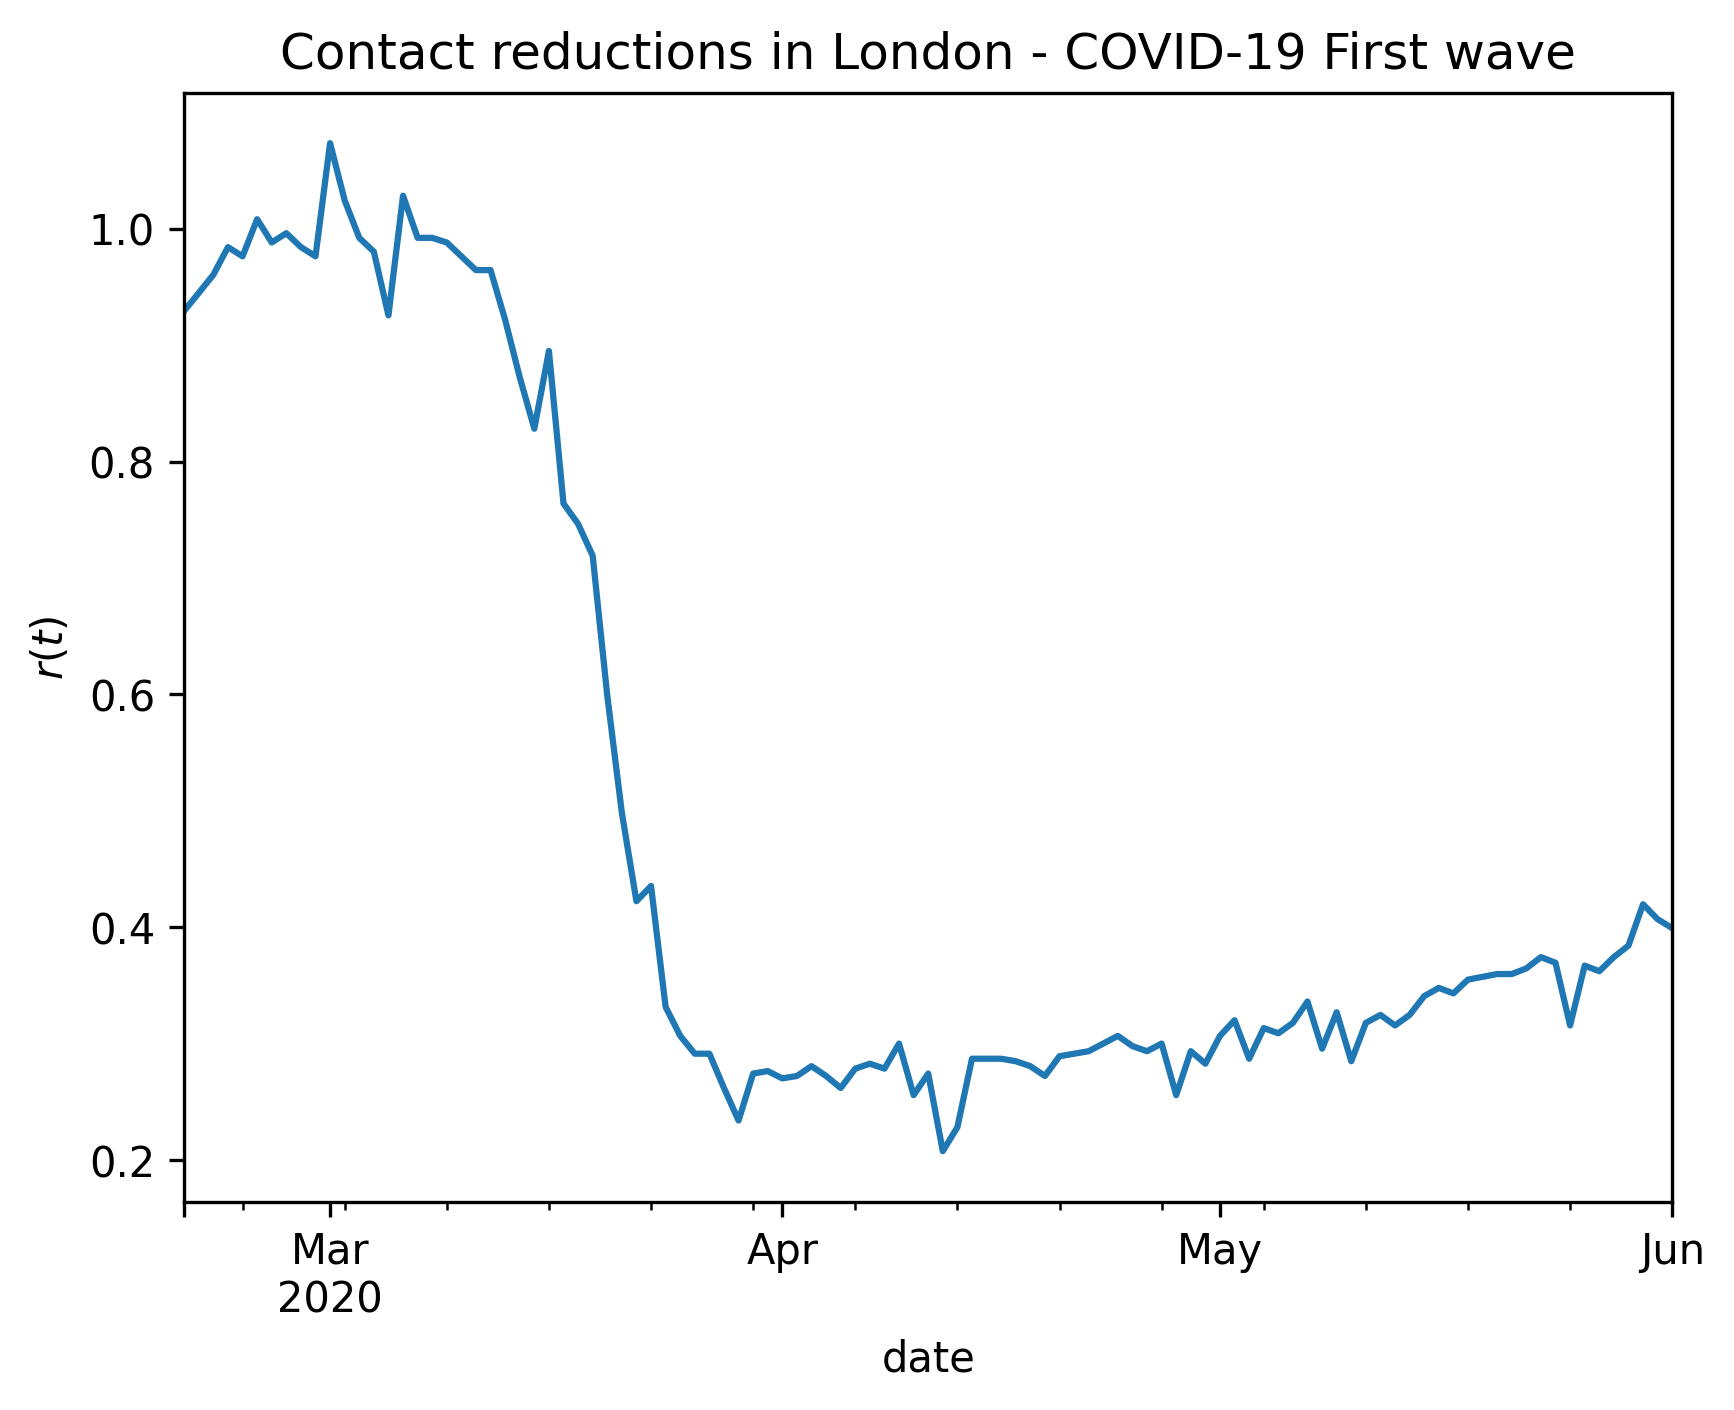

In [32]:
def compute_contact_reductions(mob_data, columns):
    return pd.DataFrame(data={'date': mob_data.date, 'r': (1 + mob_data[columns].mean(axis=1) / 100)**2})

# import google data and compute contacts reduction
mob_data = pd.read_csv(f'./data/london/google-mobility-report/google_mobility_data.csv')
mob_data = mob_data.loc[(mob_data.date >= epi_data.date.min()) & (mob_data.date <= epi_data.date.max())]
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])
contact_reductions.index = pd.to_datetime(contact_reductions.date)

fig, ax = plt.subplots(dpi=300)
contact_reductions.r.plot(ax=ax, title="Contact reductions in London - COVID-19 First wave", ylabel="$r(t)$")

We are ready to create the epidemic model. We will implement a SEIR-like model, with the addition of compartments to represent COVID-19 deaths. The model follows this schema:

MODEL SCHEMA

The multiple $D_i$ compartments are introduced to make the transitions from recovery to deaths Erlang distributed. 

In [33]:
# create model 
model = EpiModel(compartments=["S", "E", "I", "R", "D0", "D1", "D2"])

model.add_parameter(parameters_dict={"beta": 0.04, 
                                     "mu": 1. / 2.5, 
                                     "eps": 1. / 4., 
                                     "r": contact_reductions["r"].values, 
                                     "Delta": 14,
                                     "IFR": convert_to_2Darray([0.00161/100, 0.00695/100, 0.0309/100, 0.0309/100, 0.0844/100, 
                                                                0.161/100, 0.595/100, 1.93/100, 4.28/100, 7.80/100] )})

model.add_transition(source="S", target="E", rate="beta*r", agent="I")
model.add_transition(source="E", target="I", rate="eps")
model.add_transition(source="I", target="R", rate="mu*(1-IFR)")
model.add_transition(source="I", target="D0", rate="mu*IFR")
model.add_transition(source="D0", target="D1", rate="1./Delta*2")
model.add_transition(source="D1", target="D2", rate="1./Delta*2")
print(model)

EpiModel(name='EpiModel')
Compartments: 7
  S, E, I, R, D0, D1, D2
Transitions: 6
  Transitions between compartments:
    S -> E, rate: beta*r
    E -> I, rate: eps
    I -> R, rate: mu*(1-IFR)
    I -> D0, rate: mu*IFR
    D0 -> D1, rate: 1./Delta*2
    D1 -> D2, rate: 1./Delta*2
Parameters: 6
  Model parameters:
    beta: 0.04
    mu: 0.4
    eps: 0.25
    r: [0.929296 0.944784 0.9604   0.984064 0.976144 1.008016 0.988036 0.996004
 0.984064 0.976144 1.073296 1.024144 0.992016 0.9801   0.925444 1.028196
 0.992016 0.992016 0.988036 0.976144 0.964324 0.964324 0.9216   0.872356
 0.8281   0.894916 0.763876 0.746496 0.719104 0.599076 0.498436 0.4225
 0.4356   0.331776 0.306916 0.2916   0.2916   0.262144 0.234256 0.274576
 0.276676 0.2704   0.272484 0.2809   0.272484 0.262144 0.278784 0.283024
 0.278784 0.300304 0.256036 0.274576 0.207936 0.228484 0.287296 0.287296
 0.287296 0.285156 0.2809   0.272484 0.289444 0.2916   0.293764 0.300304
 0.306916 0.298116 0.293764 0.300304 0.256036 0.293764

Next, we create the London population using its demographic distribution and contact matrices:

In [ ]:
# create populaton 
population = Population(name="London")

# demographic data
demographic_data = pd.read_csv("./data/london/demographic/Nk.csv")
population.add_population(Nk=demographic_data["value"].values, 
                          Nk_names=demographic_data["group"].values)

# contact matrices
contact_matrix = np.load("./data/london/contacts-matrix/contacts_matrix_all.npz")["arr_0"]
population.add_contact_matrix(contact_matrix, layer_name="all")

# add population to the model
model.set_population(population)

We are almost ready for the calibration:

In [8]:
def custom_initial_conditions(epimodel, I0): 
    infected_by_age = np.random.multinomial(I0, epimodel.population.Nk / epimodel.population.Nk.sum())
    return {"S": epimodel.population.Nk - infected_by_age, 
            "E": (infected_by_age / 2).astype(int),
            "I": (infected_by_age / 2).astype(int)}


def compute_deaths(simulation_output, 
                   Delta,
                   IFR = [0.00161/100, 0.00695/100, 0.0309/100, 0.0309/100, 0.0844/100, 
                          0.161/100, 0.595/100, 1.93/100, 4.28/100, 7.80/100] , 
                   age_groups=['0-9', '10-19', '20-24', '25-29', '30-39', '40-49', '50-59',
                               '60-69', '70-79', '80+']):
    total_deaths = np.zeros(len(simulation_output[f"R_total"]))
    for i, age in enumerate(age_groups): 
        new_recovered = np.concatenate(([0], np.diff(simulation_output[f"R_{age}"])))
        deaths_age = np.random.binomial(new_recovered, IFR[i])
        deaths_age_shifted = np.zeros_like(deaths_age)
        deaths_age_shifted[Delta:] = deaths_age[:-Delta]
        simulation_output[f"deaths_{age}"] = deaths_age_shifted
        total_deaths += deaths_age_shifted
    simulation_output["deaths_total"] = total_deaths
    return simulation_output


def simulate_wrapper(parameters): 
    # custom initial conditions
    initial_conditions = custom_initial_conditions(parameters["epimodel"], parameters["I0"])
    parameters.update({"initial_conditions_dict": initial_conditions})
    # simulate
    results = simulate(**parameters)
    # compute deaths daily deaths    
    #results = compute_deaths(results, parameters["Delta"])
    #results.update({"data": results["deaths_total"]})
    results.update({"data": np.concatenate(([0], np.diff(results["D2_total"])))})
    return results

priors = {"beta": stats.uniform(0.04, 0.1 - 0.04), 
          "Delta": stats.randint(7, 28),
          "I0": stats.randint(10, 10000)}

simulation_dates = compute_simulation_dates(start_date=epi_data.date.values[0], end_date=epi_data.date.values[-1], steps="daily")
parameters = {"epimodel": model, 
              "simulation_dates": simulation_dates}

results = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                              priors=priors, 
                              parameters=parameters, 
                              observed_data={"data": epi_data["new_deaths"].values},  
                              num_particles=500, 
                              max_generations=5, 
                              n_jobs=8)

Generation 1: Tolerance = inf, Accepted Particles = 500/500, Time = 00:00:32, ESS = 500.0
Generation 2: Tolerance = 85.73282046482764, Accepted Particles = 500/963, Time = 00:01:18, ESS = 483.05368668194825
Generation 3: Tolerance = 69.47479811280876, Accepted Particles = 500/1021, Time = 00:01:24, ESS = 497.4804091844703
Generation 4: Tolerance = 54.24727633984274, Accepted Particles = 500/1168, Time = 00:01:57, ESS = 368.6132710361533
Generation 5: Tolerance = 43.43290775124497, Accepted Particles = 500/1300, Time = 00:02:11, ESS = 462.92486814578456


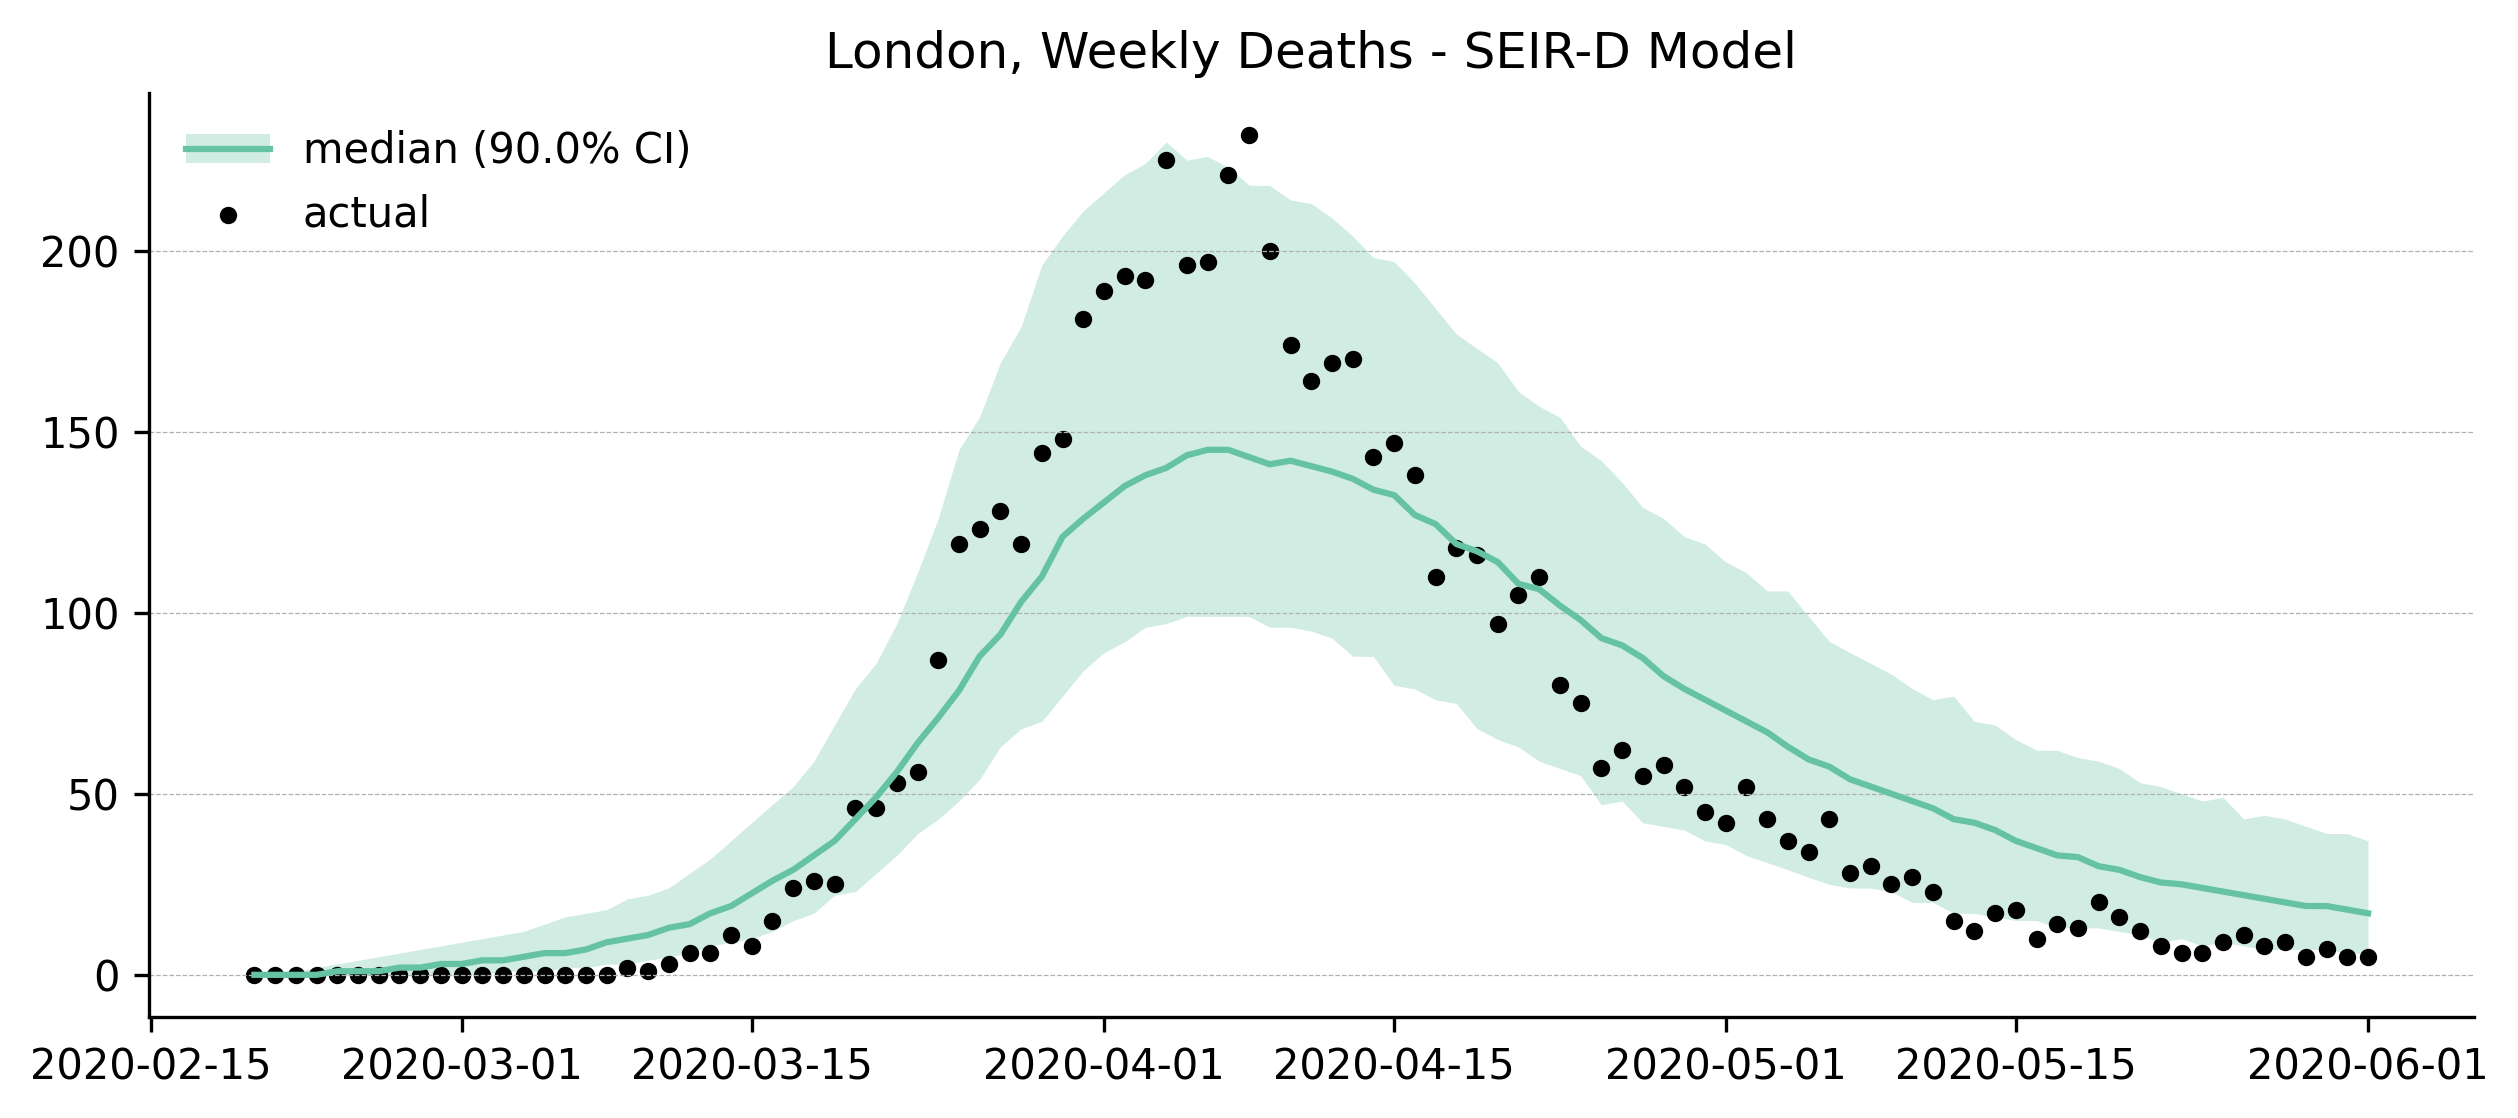

In [9]:
plot_selected_quantiles(results,  title="London, Weekly Deaths - SEIR-D Model")   

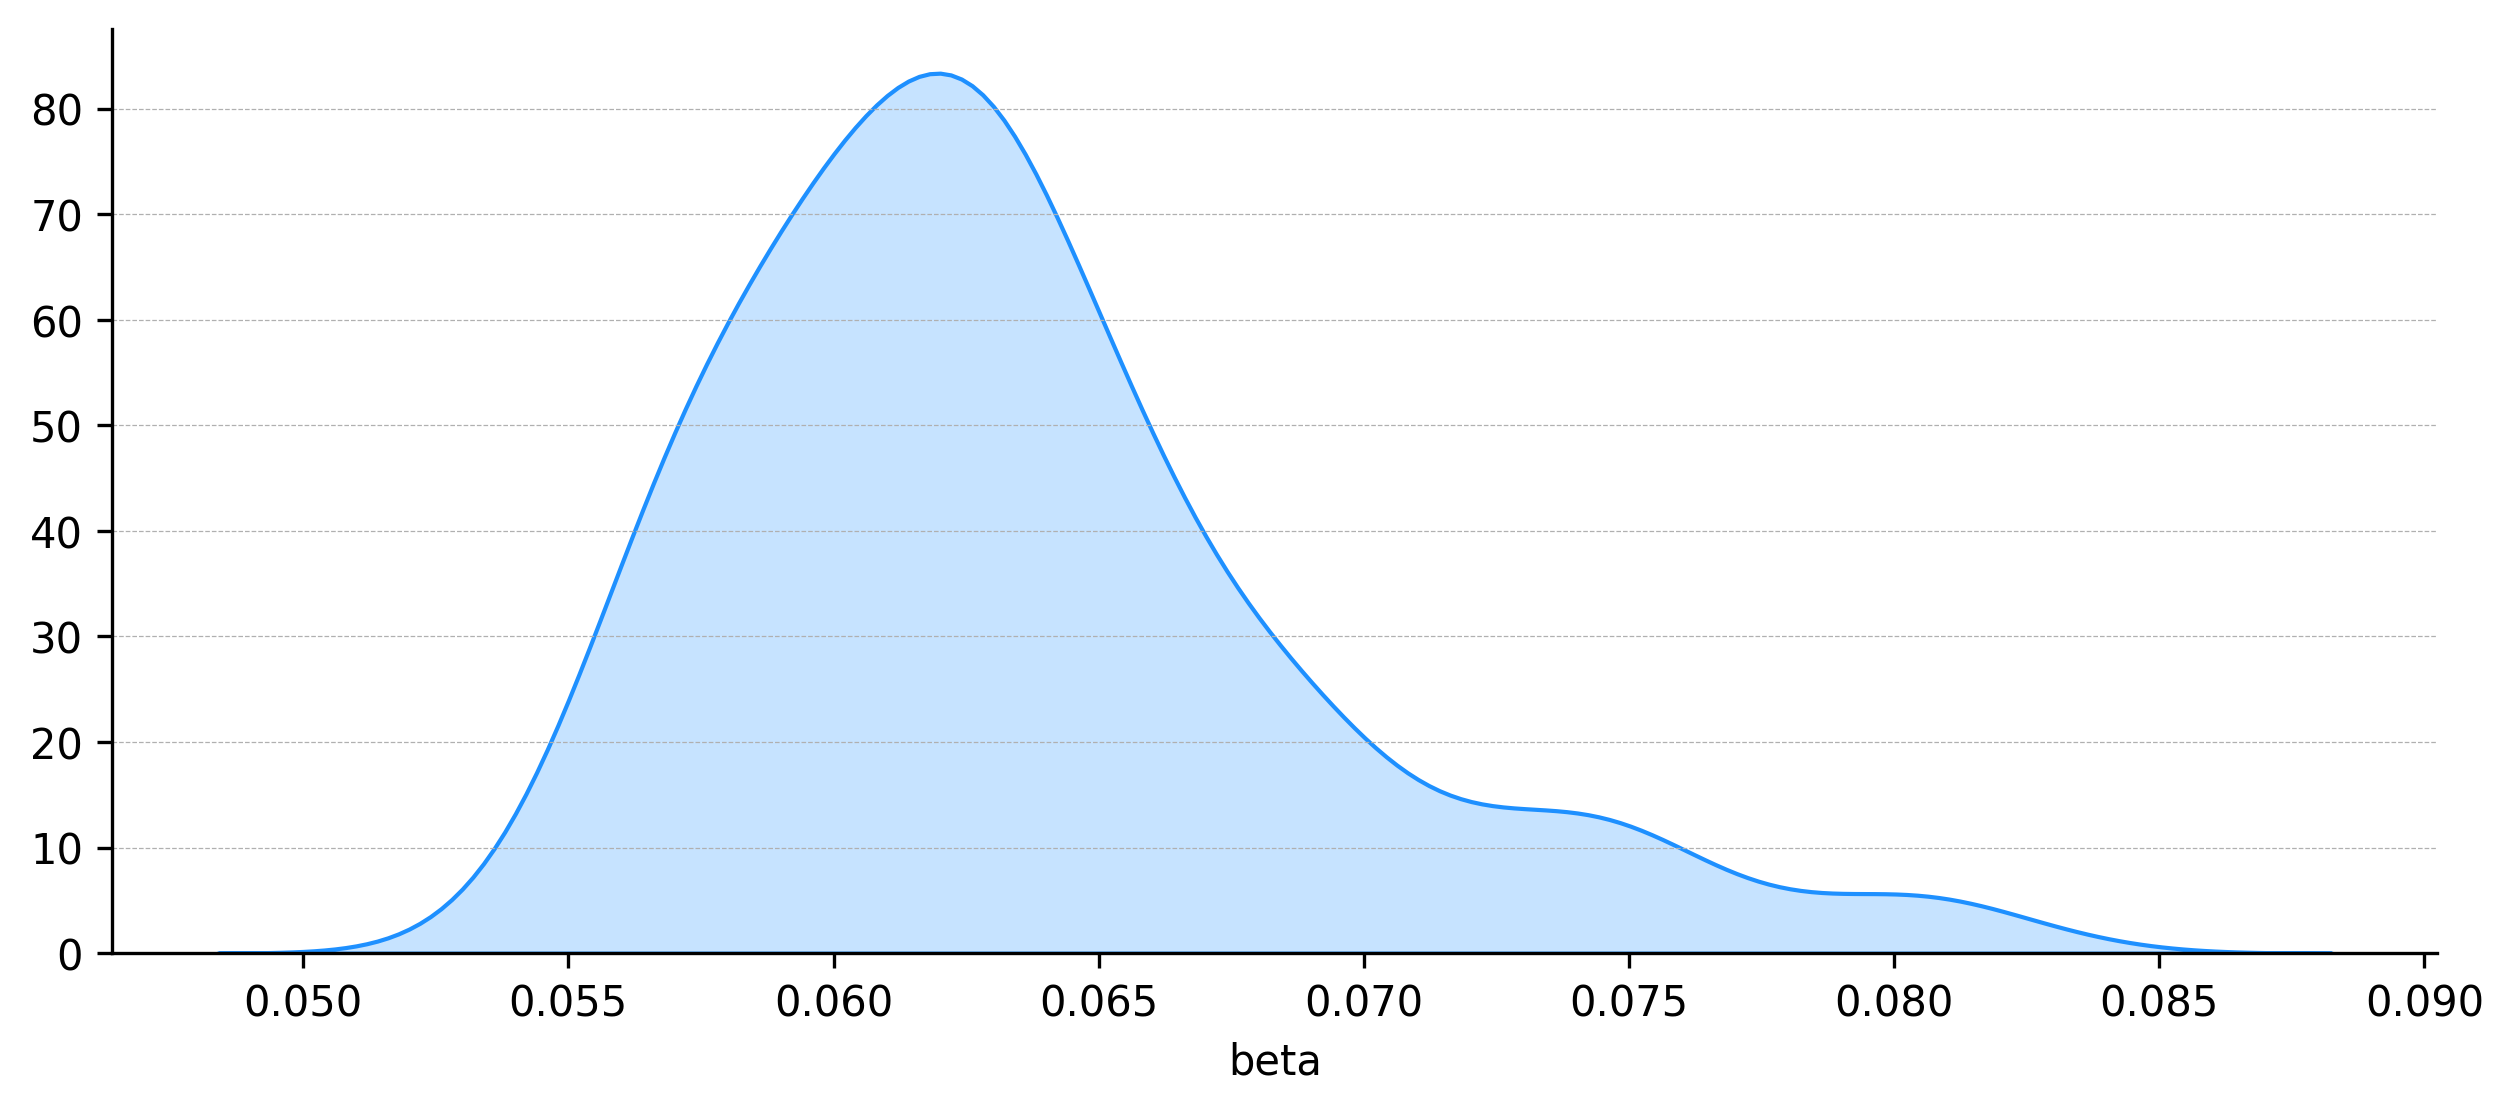

In [11]:
plot_posterior(results, "beta", kind="kde")

/Users/nicolo/Desktop/epydemix/epydemix/visualization/plotting.py:260: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


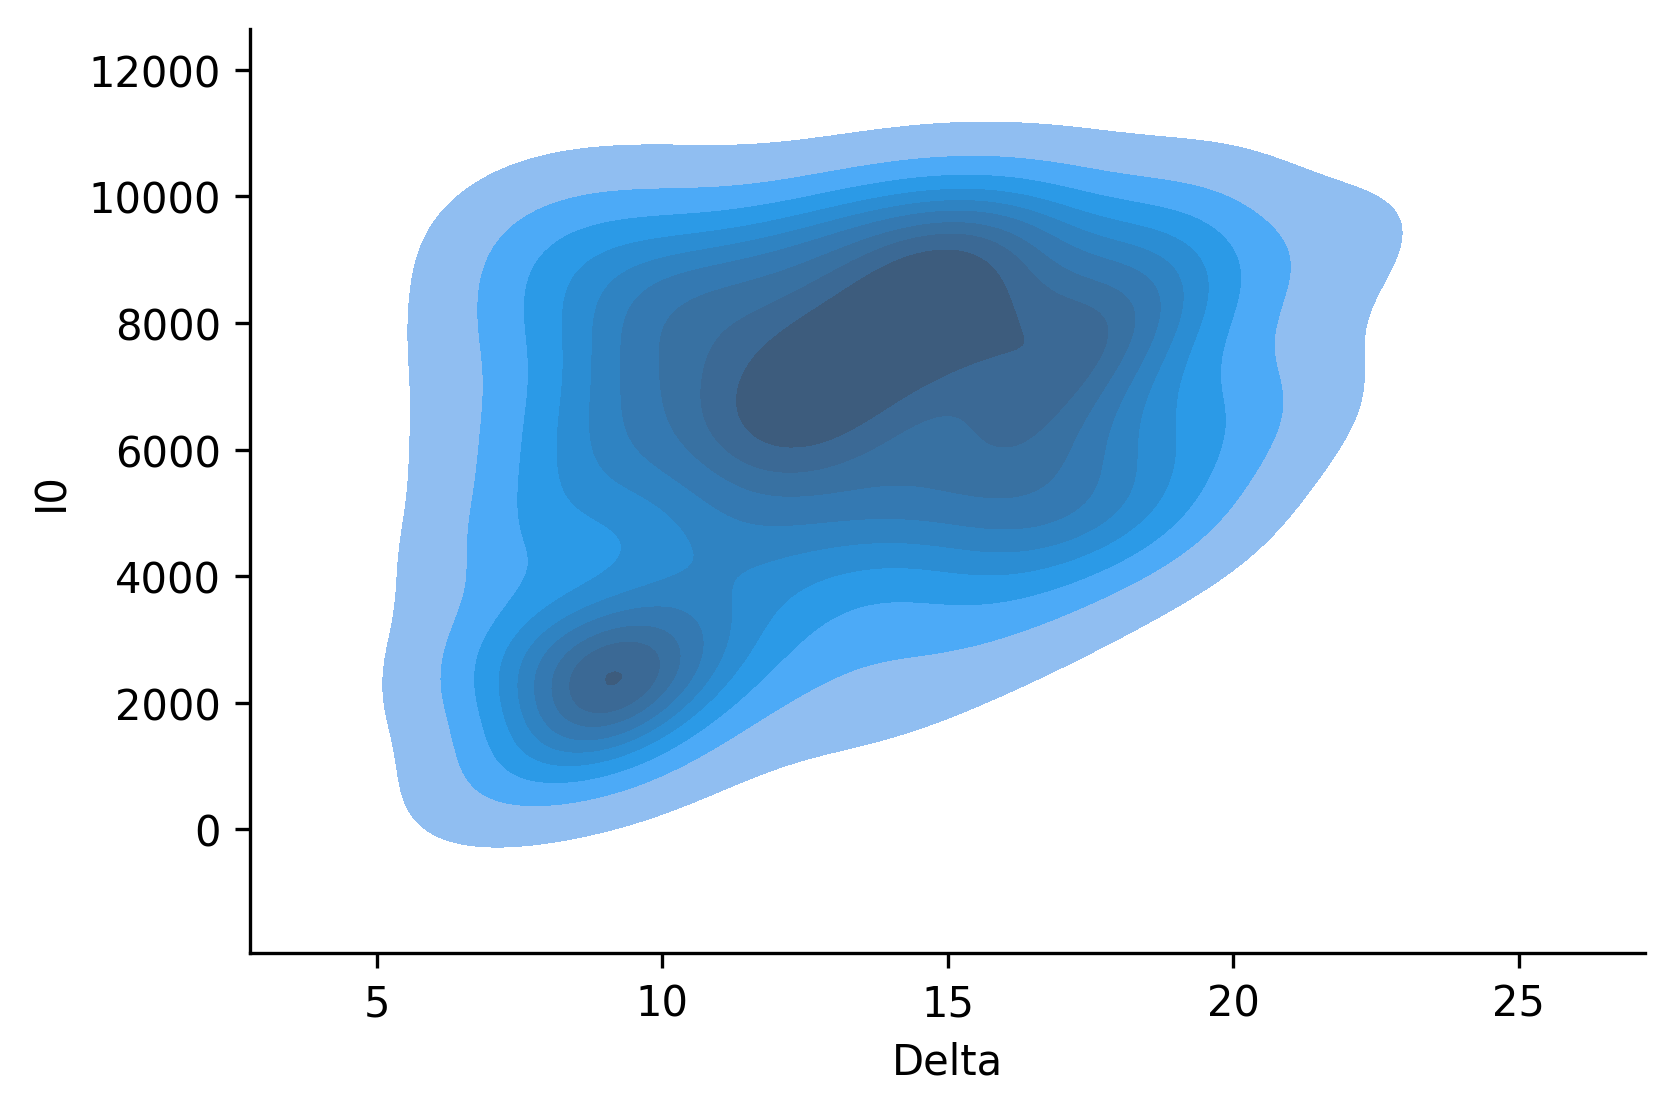

In [15]:
plot_posterior_2d(results, "Delta", "I0", kind="kde")